# Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: TBA
* Instructor name: James M Irving, Ph.D.
* Blog post URL: TBA


## Project Roadmap

#### Objectives:
The objective of this project is to produce a classification model that will predict if customers will cease their telephone services with Syria Tel.

#### Business Case:
The targeted audience would be the customer service, marketing and sales departments of the company.  The classification model will provides the audience with insights as to why we might lose a customer's subscription.  Knowing these factors is crucial as we can take corrective and preventive actions to retain the customers and prevent revenue loss.

#### Project Approach
We will follows the OSEMN framework during the project execution.  Besides, we will develop and fine tune 4 classification models using Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost.  The classifier that produces the best recall score will be adopted.

***
## Obtain Data

### Import Libraries

In [1]:
# Import various libraries
import time
from time import process_time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from my_Func import *
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Import Data

In [2]:
# Import dataset
df = pd.read_csv(r'csv\bigml_59c28831336c6604c800002a.csv')
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

***
## Clean and Scrub Data

### Inpect Columns Data Type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The dataset contains both numerical and categorical data type.  One hot encoding will be required for categorical data type.</li>
        <li>Phone number column can be dropped as it doesn't provide useful information to the model.</li>
        <li>Churn column will be our labels.  We will change its bool data type to int64.</li>
    </ul>
</div>

In [4]:
# Drop the phone number column
df.drop(columns='phone number', axis=1, inplace=True)

# Confirm drop
(df.columns == 'phone number').sum()

0

In [5]:
# Convert boolean to interger
df['churn'] = df['churn'].map({True:1, False:0})

# Verify changes
df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

### Inspect Unique Values in Columns

In [6]:
# Inspect unique values in columns
df.nunique()

state                       51
account length             212
area code                    3
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are 51 unique values in the state column.  To keep the model simple, we will group States by region.</li>
        <li>We will use the States to Region mapping obtained from <a href="https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv"</a>Github</li>
    </ul>
</div>

In [7]:
# Import the States to Region mapping dataset
df_reg = pd.read_csv('csv\st_to_rg.csv')

# Preview data
df_reg.head()

state region
0    AK   West
1    AL  South
2    AR  South
3    AZ   West
4    CA   West

In [8]:
# Merge the two dataframe
df_reg = pd.merge(df, df_reg, on='state')

# Preview data
df_reg.head()

state  account length  area code international plan voice mail plan  \
0    KS             128        415                 no             yes   
1    KS              70        408                 no              no   
2    KS              92        408                yes              no   
3    KS             137        408                 no              no   
4    KS             132        415                 no              no   

   number vmail messages  total day minutes  total day calls  \
0                     25              265.1              110   
1                      0              232.1              122   
2                      0               62.6              111   
3                      0              205.9               88   
4                      0               83.4              110   

   total day charge  total eve minutes  ...  total eve charge  \
0             45.07              197.4  ...             16.78   
1             39.46              292.3  ...             24.85   
2             10.64              180.6  ...             15.35   
3             35.00              209.3  ...             17.79   
4             14.18              232.2  ...             19.74   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                201.2                112                9.05   
2                221.7                 80                9.98   
3                289.9                 84               13.05   
4                146.7                114                6.60   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                 0.0                 0               0.00   
2                10.4                 2               2.81   
3                14.5                 4               3.92   
4                 7.6                 5               2.05   

   customer service calls  churn   region  
0                       1      0  Midwest  
1                       3      0  Midwest  
2                       1      1  Midwest  
3                       2      0  Midwest  
4                       1      0  Midwest  

[5 rows x 21 columns]

In [9]:
# Drop the state column
df_reg.drop(columns='state', axis=1, inplace=True)

# Verify drop and check unique values
df_reg.select_dtypes(object).nunique()

international plan    2
voice mail plan       2
region                4
dtype: int64

### Check Null Values

In [10]:
# Check for null values
df_reg.isna().sum()

account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
region                    0
dtype: int64

***
## Explore Data

### Descriptive Analysis

In [11]:
# Review dataset
df_reg.describe()

account length    area code  number vmail messages  total day minutes  \
count     3333.000000  3333.000000            3333.000000        3333.000000   
mean       101.064806   437.182418               8.099010         179.775098   
std         39.822106    42.371290              13.688365          54.467389   
min          1.000000   408.000000               0.000000           0.000000   
25%         74.000000   408.000000               0.000000         143.700000   
50%        101.000000   415.000000               0.000000         179.400000   
75%        127.000000   510.000000              20.000000         216.400000   
max        243.000000   510.000000              51.000000         350.800000   

       total day calls  total day charge  total eve minutes  total eve calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   
std          20.069084          9.259435          50.713844        19.922625   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.430000         166.600000        87.000000   
50%         101.000000         30.500000         201.400000       100.000000   
75%         114.000000         36.790000         235.300000       114.000000   
max         165.000000         59.640000         363.700000       170.000000   

       total eve charge  total night minutes  total night calls  \
count       3333.000000          3333.000000        3333.000000   
mean          17.083540           200.872037         100.107711   
std            4.310668            50.573847          19.568609   
min            0.000000            23.200000          33.000000   
25%           14.160000           167.000000          87.000000   
50%           17.120000           201.200000         100.000000   
75%           20.000000           235.300000         113.000000   
max           30.910000           395.000000         175.000000   

       total night charge  total intl minutes  total intl calls  \
count         3333.000000         3333.000000       3333.000000   
mean             9.039325           10.237294          4.479448   
std              2.275873            2.791840          2.461214   
min              1.040000            0.000000          0.000000   
25%              7.520000            8.500000          3.000000   
50%              9.050000           10.300000          4.000000   
75%             10.590000           12.100000          6.000000   
max             17.770000           20.000000         20.000000   

       total intl charge  customer service calls        churn  
count        3333.000000             3333.000000  3333.000000  
mean            2.764581                1.562856     0.144914  
std             0.753773                1.315491     0.352067  
min             0.000000                0.000000     0.000000  
25%             2.300000                1.000000     0.000000  
50%             2.780000                1.000000     0.000000  
75%             3.270000                2.000000     0.000000  
max             5.400000                9.000000     1.000000

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Some columns exhibit great variances.  Data normalization will be required.</li>
        <li>No details can be found regarding the unit for "account length".  However, based on the "total day calls" values, it is safe to assume the unit for "account length" is in days.</li>
        <li>Based on the above assumption, the data seem to represent new customers as the max value in "account length" is 243 days or 8.1 months and on an average accounts are 101 days old.</li>
    </ul>
</div>

### Investigate Churn Column

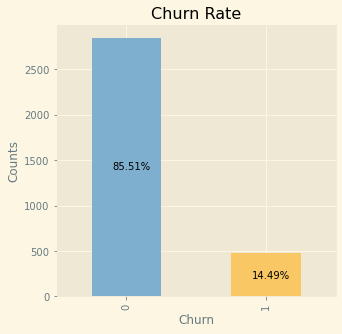

In [12]:
# # Checking churn data distribution
nc_percent = round(df_reg.churn.value_counts(normalize=True)[0]*100,2)
c_percent = round(df_reg.churn.value_counts(normalize=True)[1]*100,2)

with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(5,5))
    df_reg['churn'].value_counts().plot(kind='bar', color=['#7FAFCE',
                                                           '#F9C764'])
    plt.text(-0.1, 1400, f'{nc_percent}%')
    plt.text(.90, 200, f'{c_percent}%')
    plt.xlabel('Churn')
    plt.ylabel('Counts')
    plt.title('Churn Rate')
    plt.show()


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>14.49% of the customers in the dataset canceled their services.</li>
        <li>The dataset is clearly unbalanced. Resampling techniques will be required.</li>
    </ul>
</div>

### Check Columns Features Correlation with Churn

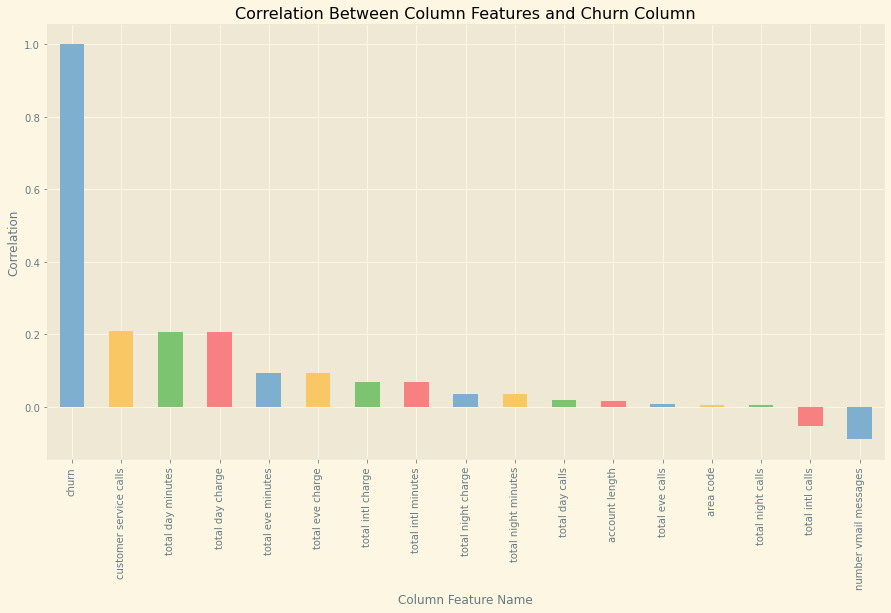

In [13]:
# Plot correlation between columns and churn
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(15,8))
    df_reg.corr()['churn'].sort_values(ascending = False)\
                            .plot(kind='bar',
                             color=['#7FAFCE','#F9C764','#7CC470', '#F78181'])
    plt.xlabel('Column Feature Name')
    plt.ylabel('Correlation')
    plt.title('Correlation Between Column Features and Churn Column')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>None of the column feature shows a strong correlation with the churn column.</li>
        <li>'Total intl calls' and 'number vmail messages' appear to be inversely correlated to the churn column.</li>
    </ul>
</div>

### Check Multicollinearity Among Independent Variables

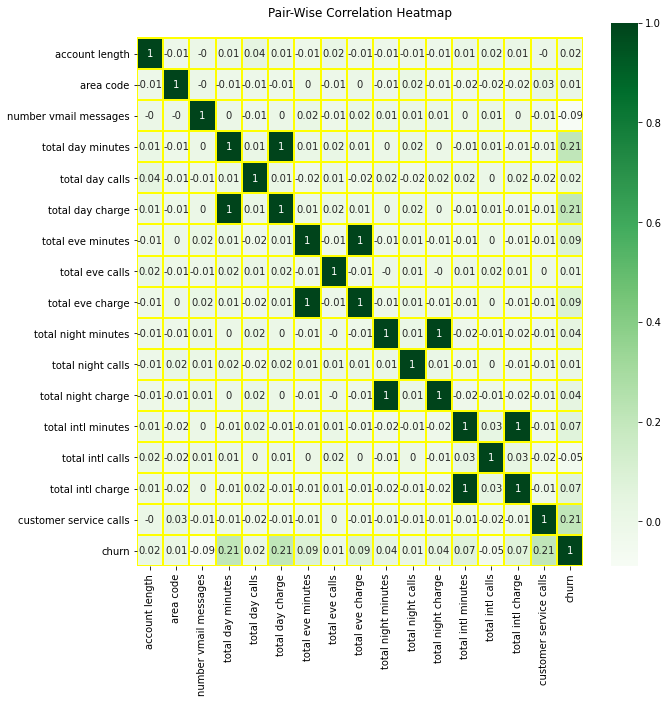

In [14]:
# A graphical representation of the pair-wise correlation using heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(round(df_reg.iloc[:,].corr(), 2), cmap='Greens',
            annot=True, linewidths=1, linecolor='yellow')
ax.set_ylim(len(df_reg.iloc[:,:].corr())-0, -0.5)
ax.set_title("Pair-Wise Correlation Heatmap")
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are a few independent features showing perfect correlation with one another.</li>
        <li>We will need to drop 'total day charge', 'total eve charge', 'total night charge' and 'total intl charge' so we don't violate the multicollinearity assumption for Logistic Regression.</li>
        <li>After dropping the 4 columns, we still have 16 columns available to meet the project requirements.
    </ul>
</div>

### Check Column Features by Churn

In [15]:
# Assign categorical and numerical column names to variables
cat_fea = df_reg.select_dtypes(object).columns
int_fea = df_reg.select_dtypes('int64').columns
flt_fea = df_reg.select_dtypes('float64').columns

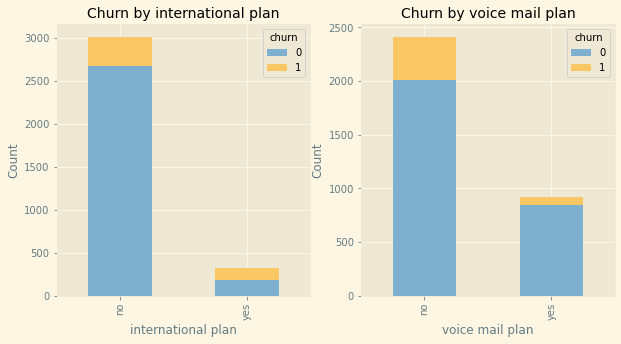

In [16]:
# Plot the churn rate by categorical features
with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    for xcol, ax in zip(['international plan', 'voice mail plan'], axes):
        df_reg.groupby([xcol, 'churn']).size().unstack().plot(kind='bar',
                                                              stacked=True, ax=ax,
                                                              color=['#7FAFCE','#F9C764'])
        ax.set_ylabel('Count')
        ax.set_title(f'Churn by {xcol}', size=14)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rates are higher for customers with an international plan.  Almost half of the international plan subscribers canceled their services while only a smaller portion of the customers without a international plan canceled their accounts.</li>
        <li>Customers without the voice mail plan have substantial more cancellations.</li>
    </ul>
</div>

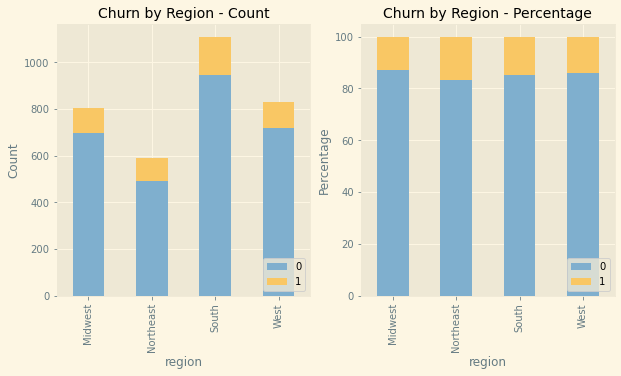

In [17]:
# Calculate Region churn rate percentage
st_churn = (df_reg.groupby('region')['churn'].value_counts(normalize=True)* 100).unstack()

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    df_reg.groupby(['region', 'churn']).size().unstack().plot(kind='bar',
                                                              stacked=True, ax=ax1,
                                                              color=['#7FAFCE','#F9C764'])
    ax1.set_title('Churn by Region - Count', size=14)
    ax1.set_ylabel('Count')
    ax1.legend(loc='lower right')
    st_churn.plot(kind='bar', stacked=True, ax=ax2, color=['#7FAFCE','#F9C764'])
    ax2.set_title('Churn by Region - Percentage', size=14)
    ax2.set_ylabel('Percentage')
    ax2.legend(loc='lower right')

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>We have more customers in the South region.</li>
        <li>Although Northeast makes up the smallest portion of the customer base, it has the highest customer churn.</li>
    </ul>
</div>

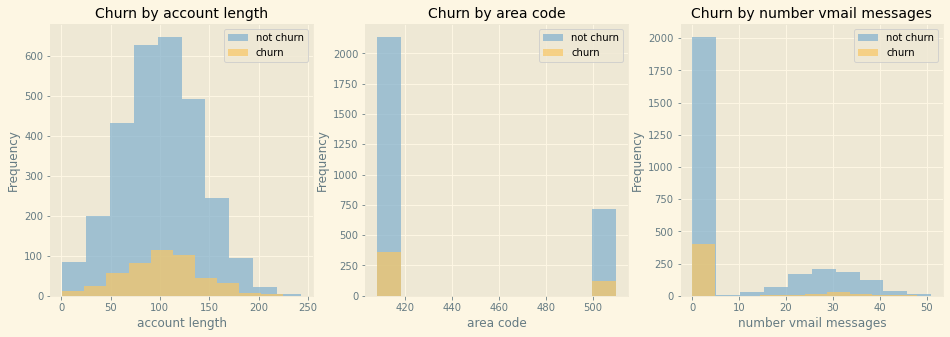

In [18]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (0,3))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rate is at the highest when customers have the services for 3 months or so. We wonder this could be due to some type of promotional periods expiring and people are canceling their services.</li>
        <li>There are only 3 area codes for 51 states, which doesn't add up.  We will drop the column. </li>
        <li>Customers with very few voice mail messages or no voice mail, due to the fact that they don't have a voice mail plan, tend to have a higher cancellations.</li>
    </ul>
</div>

In [19]:
# Drop the area code column
df_reg.drop(columns='area code', axis=1, inplace=True)

# Verify drop
(df_reg.columns == 'area code').sum()

0

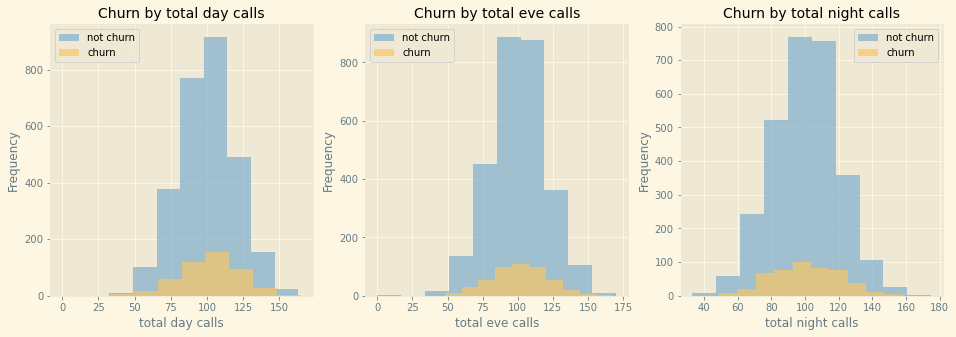

In [20]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (3,6))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Data appear to be normally distributed for 'Churn' and 'Not Churn'.</li>
    </ul>
</div>

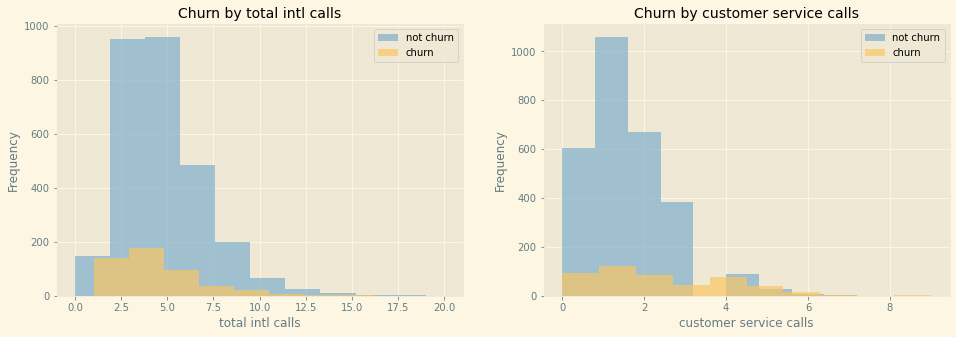

In [21]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (6,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The true churn rate by total international calls seems to be proportionally related to false churn rates.  Both display similar data distribution.</li>
        <li>There are more 'Churn' than 'Not Churn' when the 'customer service calls' value is more than 3.
    </ul>
</div>

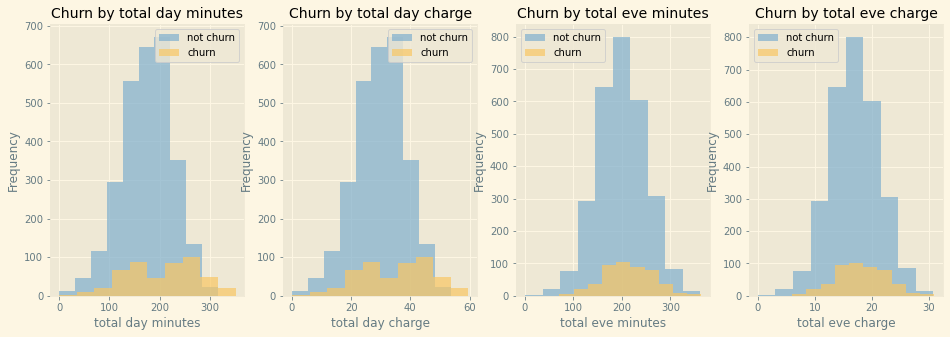

In [22]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, flt_fea, (0,4))

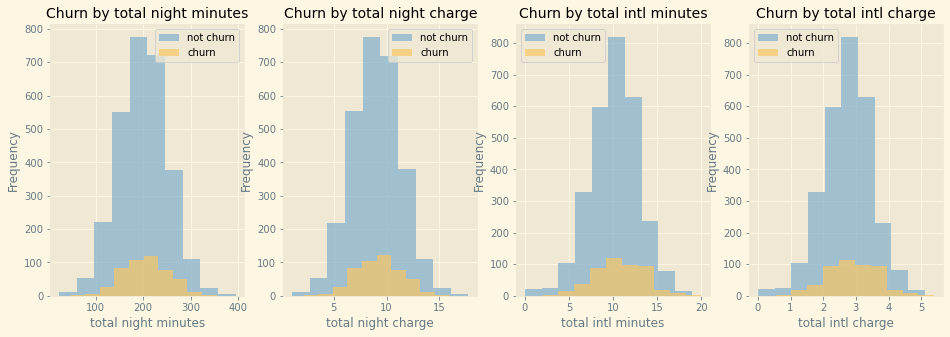

In [23]:
# Plot numerical churn rate by numerical features
fea_churn_plot(df_reg, flt_fea, (4,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Features data seem to be normally distributed.</li>
        <li>Most true churn rates occur around the mean of the features.</li>
        <li>Total day minutes and total day charge upper bins do not contain any false churn rates.  We saw 100% true churn rates in the upper bins.</li>
    </ul>
</div>

In [24]:
# Drop 'total day charge', 'total eve charge', 'total night charge'
# and 'total intl charge' due to perfect correlation
col_to_drop = ['total day charge', 'total eve charge',
               'total night charge', 'total intl charge'] 

df_reg.drop(columns=col_to_drop, axis=1, inplace=True)

# Verify drop
len([col for col in df_reg.columns if 'charge' in col])

0

***
## Premodeling Preparations

### Create Train Test Split

In [25]:
# Separate labels and features
y = df_reg.churn.copy()
X = df_reg.drop(columns='churn', axis=1).copy()

# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36 )
print(X_train.shape, X_test.shape)

(2499, 14) (834, 14)


### One Hot Encoding

In [26]:
# One hot encoding training data
X_train_ohe = pd_ohe(X_train)

# Preview data
X_train_ohe.head()

international plan_yes  voice mail plan_yes  region_Northeast  \
996                        0                    0                 0   
1396                       0                    1                 0   
2421                       1                    0                 0   
642                        0                    0                 0   
2191                       0                    0                 0   

      region_South  region_West  account length  number vmail messages  \
996              0            1              31                      0   
1396             0            1             118                     36   
2421             0            1             124                      0   
642              0            0              65                      0   
2191             0            1              97                      0   

      total day minutes  total day calls  total eve minutes  total eve calls  \
996               177.3              129              152.8              105   
1396              294.9              106              165.7              115   
2421              244.6               89              188.8               80   
642               129.1              137              228.5               83   
2191              146.0              121              203.0              141   

      total night minutes  total night calls  total intl minutes  \
996                 162.9                 92                 5.1   
1396                189.2                 63                 9.8   
2421                206.0                114                11.3   
642                 208.8                111                12.7   
2191                151.8                120                13.3   

      total intl calls  customer service calls  
996                  2                       0  
1396                 5                       3  
2421                 4                       1  
642                  6                       4  
2191                 2                       1

In [27]:
# One hot encoding test data
X_test_ohe = pd_ohe(X_test)

# Preview data
X_test_ohe.head()

international plan_yes  voice mail plan_yes  region_Northeast  \
1038                       0                    1                 0   
3241                       0                    1                 1   
1523                       0                    1                 0   
532                        0                    0                 0   
1013                       0                    0                 0   

      region_South  region_West  account length  number vmail messages  \
1038             0            1              47                     28   
3241             0            0             146                     23   
1523             0            0             131                     36   
532              1            0              62                      0   
1013             0            1              60                      0   

      total day minutes  total day calls  total eve minutes  total eve calls  \
1038              172.9              109              137.6               94   
3241              149.6               96              239.8              124   
1523              214.2              115              161.7              117   
532               186.8               94              207.6               92   
1013              221.1              106              178.6               48   

      total night minutes  total night calls  total intl minutes  \
1038                203.8                109                 8.3   
3241                293.5                135                 7.4   
1523                264.7                102                 9.5   
532                 195.0                 98                 8.8   
1013                202.7                 90                 7.4   

      total intl calls  customer service calls  
1038                 6                       1  
3241                 4                       2  
1523                 4                       3  
532                  4                       3  
1013                 3                       1

***
## Baseline Model

### Fit Model

In [28]:
# Define list of classifiers to feed to pipeline
clfs = [LogisticRegression(random_state=36), KNeighborsClassifier(),
        RandomForestClassifier(random_state=36), xgb.XGBClassifier(random_state=36)]

In [29]:
# Assign train and test dataset to list to pass to function
df_baseline = [X_train_ohe, y_train, X_test_ohe, y_test]

### Plot Confusion Matrix

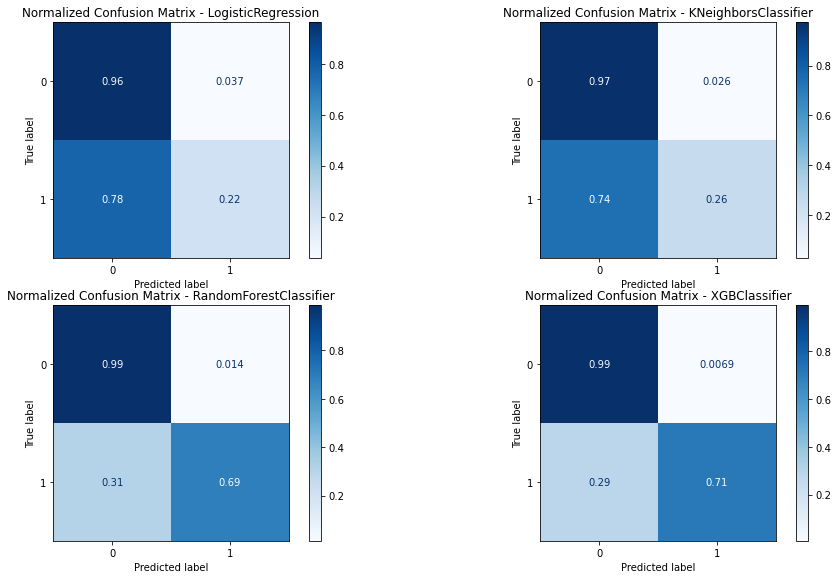

In [30]:
# Fit model, generate classifcation report and plot confusion matrix
# base_mdl_clf_rpt, clf_dict = fit_eval_clf(clfs, X_train_ohe, y_train, X_test_ohe, y_test)
base_mdl_clf_rpt, clf_dict = fit_eval_clf(clfs, df_baseline)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>All 4 classifiers did very well in predicting true negative, i.e. the false churn.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>XGBoost performed remarkably in predicting true positive as was Random Forest.  Can't say the same for Logistic Regression and K-Nearest Neighbors (KNN).</li>
        </ul>
</div>

### Plot Comparison Chart

In [31]:
# Display model classification report
base_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.888747  0.962604  0.924202  722.000000   
Churn                  0.480769  0.223214  0.304878  112.000000   
accuracy               0.863309  0.863309  0.863309    0.863309   
macro avg              0.684758  0.592909  0.614540  834.000000   
weighted avg           0.833958  0.863309  0.841032  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.894402  0.973684  0.932361  722.000000   
Churn                    0.604167  0.258929  0.362500  112.000000   
accuracy                 0.877698  0.877698  0.877698    0.877698   
macro avg                0.749284  0.616306  0.647430  834.000000   
weighted avg             0.855426  0.877698  0.855833  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.953146  0.986150  0.969367  722.000000   
Churn                      0.885057  0.687500  0.773869  112.000000   
accuracy                   0.946043  0.946043  0.946043    0.946043   
macro avg                  0.919102  0.836825  0.871618  834.000000   
weighted avg               0.944002  0.946043  0.943113  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.957276  0.993075  0.974847  722.000000  
Churn             0.941176  0.714286  0.812183  112.000000  
accuracy          0.955635  0.955635  0.955635    0.955635  
macro avg         0.949226  0.853680  0.893515  834.000000  
weighted avg      0.955114  0.955635  0.953002  834.000000

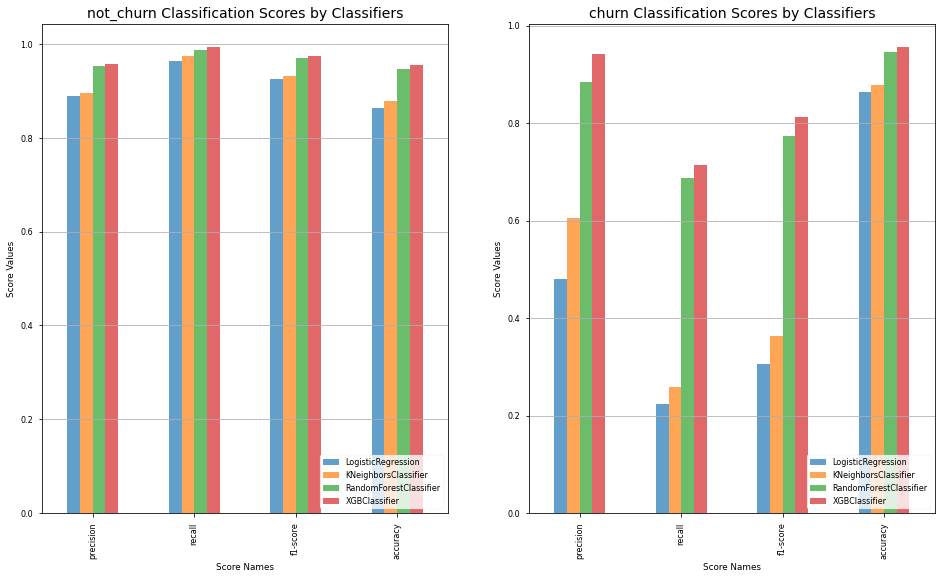

In [32]:
# Plot comparison chart
plot_clf_rpt(base_mdl_clf_rpt, clf_dict)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Across the 4 scores, Logistic Regression fared the worst.  XGBoost came out on top among the 4 classifiers.</li>
            <li>All models reported an impressive recall score of over 90%.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Logistic Regression's performance pale compared to the other three classifiers.  Again, XGBoost came out on top as the best model.</li>
            <li>Recall and f1_score values were low which might be caused by the class imbalance issue.</li>
        </ul>
</div>

***
## Fine Tune Models

### Address Class Imbalance Problem

In [33]:
# Use SMOTE since we don't have a lot of features and data, computational issues are mininum
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train_ohe, y_train)

# Check new train dataset
print(pd.Series(y_train_smote.value_counts()))            

1    2128
0    2128
Name: churn, dtype: int64


### Fit Model with Resample Data

In [34]:
# Assign X, y data sets to variable
df_smote = [X_train_smote, y_train_smote, X_test_ohe, y_test]

In [35]:
# Fit model, generate classification report and plot confusion matrix
smote_mdl_clf_rpt, smote_clf_dict = fit_eval_clf(clfs, df_smote, disp_cm=False)

In [36]:
# Display classificaiton report
smote_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.916667  0.777008  0.841079  722.000000   
Churn                  0.274775  0.544643  0.365269  112.000000   
accuracy               0.745803  0.745803  0.745803    0.745803   
macro avg              0.595721  0.660826  0.603174  834.000000   
weighted avg           0.830465  0.745803  0.777182  834.000000   

             KNeighborsClassifier                                 \
                        precision    recall  f1-score    support   
Not Churn                0.907618  0.775623  0.836445  722.00000   
Churn                    0.253456  0.491071  0.334347  112.00000   
accuracy                 0.737410  0.737410  0.737410    0.73741   
macro avg                0.580537  0.633347  0.585396  834.00000   
weighted avg             0.819769  0.737410  0.769017  834.00000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.929635  0.951524  0.940452  722.000000   
Churn                      0.631579  0.535714  0.579710  112.000000   
accuracy                   0.895683  0.895683  0.895683    0.895683   
macro avg                  0.780607  0.743619  0.760081  834.000000   
weighted avg               0.889608  0.895683  0.892007  834.000000   

             XGBClassifier                                 
                 precision    recall  f1-score    support  
Not Churn         0.955777  0.927978  0.941673  722.00000  
Churn             0.609023  0.723214  0.661224  112.00000  
accuracy          0.900480  0.900480  0.900480    0.90048  
macro avg         0.782400  0.825596  0.801449  834.00000  
weighted avg      0.909211  0.900480  0.904010  834.00000

### Plot Performance Gain/Loss SMOTE vs Base

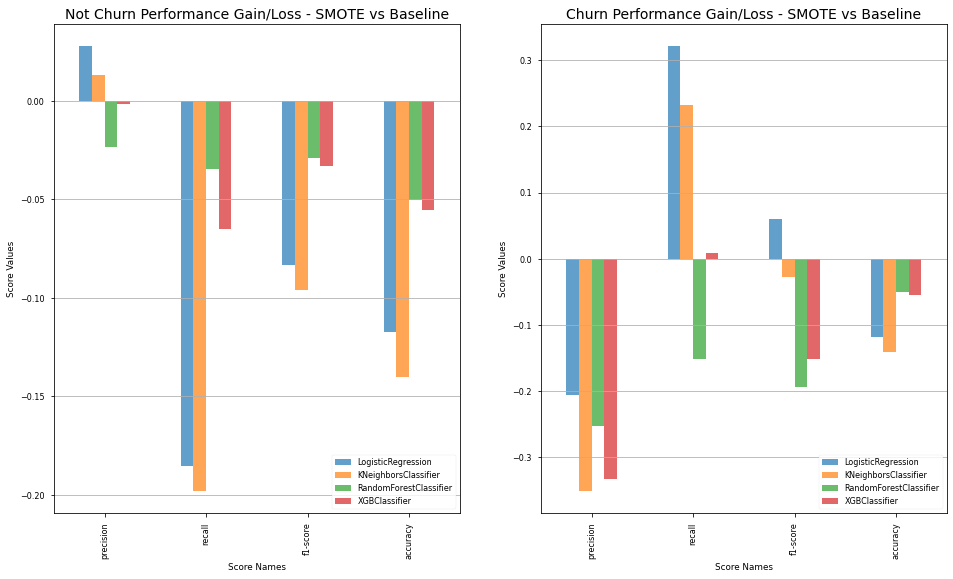

In [37]:
# Plot performance gain/loss between model with SMOTE treatment and without
plot_gain_loss(smote_mdl_clf_rpt, base_mdl_clf_rpt, {'f_churn': 'Not Churn',
                                                     't_churn': 'Churn'},
                                                     'SMOTE vs Baseline')

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>After resampling the training data with SMOTE, there is slight decrease in all the scores among the models, except Logistic Regression and KNN models, showing small gain in the precision scores.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>The Logistic Regression and the KNN models seem to benefit the most from the SMOTE sampling, both showing slight gain in recall score.</li>
        </ul>
</div>

### Grid Search Hyperparameters

In [38]:
# Establish GridSearch parameter grids for the models

# fit_intercept, add bias if true.  Small C = stronger regularization
# Since sample data are quite small and doesn't involve multi class, set solver to liblinear
# liblinear only works with penalty 'l1', omit 'l2' from parameter
lr_params = {'lr__fit_intercept': [True, False],
             'lr__C': [0.001,0.01,0.1,1,10,100,1000],
             'lr__penalty': ['l1'],
             'lr__solver': ['liblinear']}

# A lower n_neighbors = more complex model.  Distance in weight means closer neighbors
# of a query point will have a greater influnce.
knn_params = {'knn__n_neighbors': list(range(1, 33, 2)),
              'knn__metric': ['euclidean', 'minkowski'],
              'knn__weights': ['uniform', 'distance']}

# n_estimators = number of trees in the foreset; max_features = max number of features
# considered for splitting a node; max_dept = max number of levels in each decision tree
# min_samples_leaf = min number of data points allowed in a leaf node
rf_params = {'rf__n_estimators': [5, 30, 100, 170, 250],
             'rf__max_features': ['auto', 'sqrt', 'log2'],
             'rf__max_depth' : [4,5,6,7,8],
             'rf__min_samples_leaf': [3, 5, 7]}

# min_child_weight = min_sample_leaf; 
xg_params = {'xg__n_estimators': [5, 30, 100, 170, 250],
             'xg__max_depth': range(3,10,2),
             'xg__min_child_weight': list(range(1,6,2)),
             'xg__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# Set up functions parameters
alg_dict = {'lr': LogisticRegression(max_iter=10000, random_state=36), 'knn': KNeighborsClassifier(),
            'rf': RandomForestClassifier(random_state=36), 'xg': xgb.XGBClassifier(random_state=36)}

mdl_params = {'lr_grd_sch': lr_params, 'knn_grd_sch': knn_params,
              'rf_grd_sch': rf_params , 'xg_grd_sch': xg_params}

In [39]:
# Run gridsearchcv.  Cell takes 22 min.  Could not set n_jobs=-1 as it messed up the timer.
df_grdsch_mdl = fit_evl_grdsch(alg_dict, mdl_params, df_smote)

running gridsearch for lr
total elapsed time 00:00:01
running gridsearch for knn
total elapsed time 00:00:39
running gridsearch for rf
total elapsed time 00:07:45
running gridsearch for xg
total elapsed time 00:13:07


In [40]:
# View Results
df_grdsch_mdl

no_model exec_time                                        best_params  \
lr         14  00:00:01  {'lr__C': 10, 'lr__fit_intercept': False, 'lr_...   
knn        64  00:00:39  {'knn__metric': 'euclidean', 'knn__n_neighbors...   
rf        225  00:07:45  {'rf__max_depth': 8, 'rf__max_features': 'auto...   
xg        360  00:13:07  {'xg__learning_rate': 0.3, 'xg__max_depth': 5,...   

                                              best_est  best_score  
lr   (StandardScaler(), LogisticRegression(C=10, fi...    0.775915  
knn  (StandardScaler(), KNeighborsClassifier(metric...    0.943647  
rf   (StandardScaler(), (DecisionTreeClassifier(max...    0.813022  
xg   (StandardScaler(), XGBClassifier(learning_rate...    0.933306

### Fit Models with New Parameters

In [41]:
# Define list of classifiers to feed to pipeline
grdsch_clfs = []
for i in range(len(df_grdsch_mdl.best_est.values)):
    est = df_grdsch_mdl.best_est.values[i][-1]
    print(est)
    grdsch_clfs.append(est)

LogisticRegression(C=10, fit_intercept=False, max_iter=10000, penalty='l1',
                   random_state=36, solver='liblinear')
KNeighborsClassifier(metric='euclidean', n_neighbors=1)
RandomForestClassifier(max_depth=8, min_samples_leaf=3, random_state=36)
XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=250, random_state=36)


### Plot Confusion Matrix

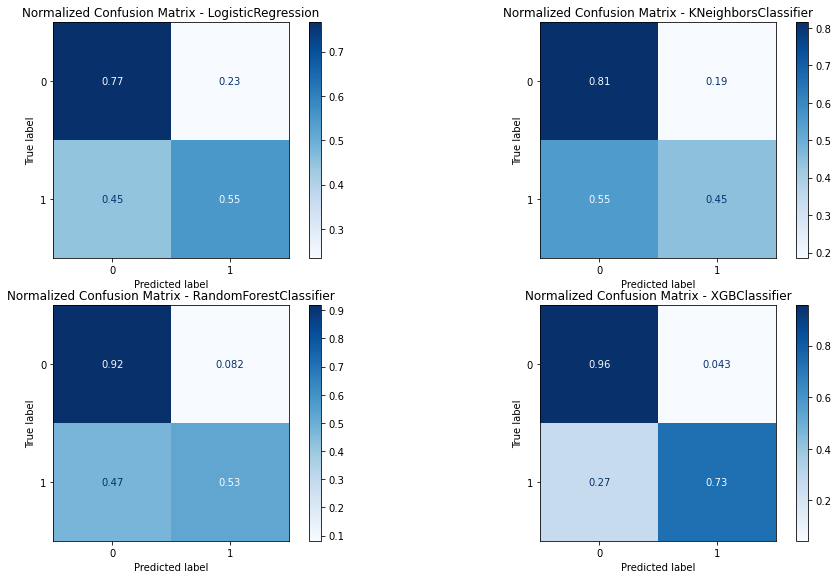

In [42]:
# Fit model, generate classification report and plot confusion matrix with best estimators
grdsch_mdl_clf_rpt, grdsch_clf_dict = fit_eval_clf(grdsch_clfs, df_smote)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>All four models reported a drop in True negative prediction but showed gain in True positive prediction, except the Random Forest model.</li>
        <li>We will get a better picture when we plot the performance gain/log figure.</li>
    </ul>
</div>

### Plot Comparison Chart

In [43]:
# View classification report
grdsch_mdl_clf_rpt

LogisticRegression                                 \
                      precision    recall  f1-score    support   
Not Churn              0.917081  0.765928  0.834717  722.00000   
Churn                  0.268398  0.553571  0.361516  112.00000   
accuracy               0.737410  0.737410  0.737410    0.73741   
macro avg              0.592740  0.659750  0.598117  834.00000   
weighted avg           0.829968  0.737410  0.771170  834.00000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.904615  0.814404  0.857143  722.000000   
Churn                    0.271739  0.446429  0.337838  112.000000   
accuracy                 0.764988  0.764988  0.764988    0.764988   
macro avg                0.588177  0.630417  0.597490  834.000000   
weighted avg             0.819625  0.764988  0.787404  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.925978  0.918283  0.922114  722.000000   
Churn                      0.500000  0.526786  0.513043  112.000000   
accuracy                   0.865707  0.865707  0.865707    0.865707   
macro avg                  0.712989  0.722534  0.717579  834.000000   
weighted avg               0.868772  0.865707  0.867179  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.958391  0.957064  0.957727  722.000000  
Churn             0.725664  0.732143  0.728889  112.000000  
accuracy          0.926859  0.926859  0.926859    0.926859  
macro avg         0.842027  0.844603  0.843308  834.000000  
weighted avg      0.927138  0.926859  0.926996  834.000000

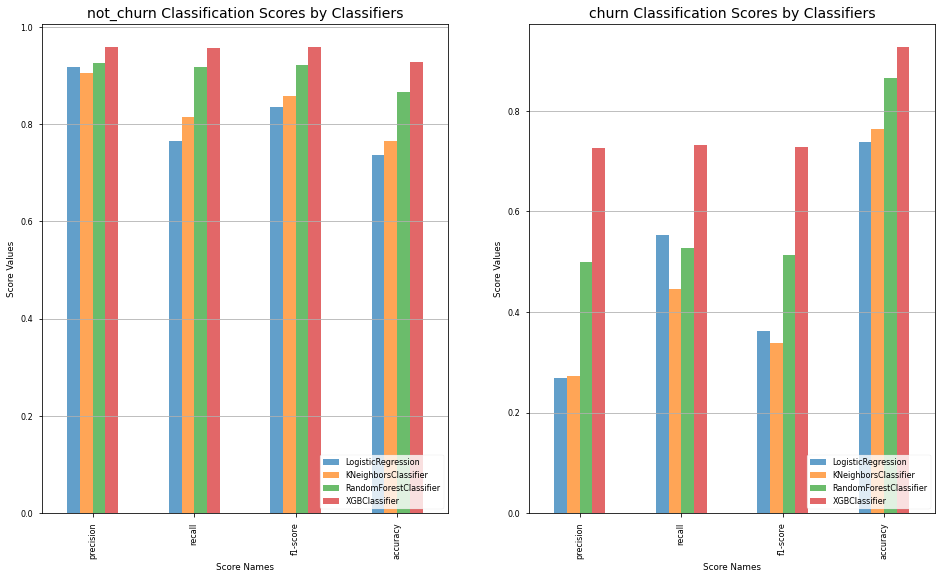

In [44]:
# Plot comparison chart
plot_clf_rpt(grdsch_mdl_clf_rpt, grdsch_clf_dict)

### Plot Performance Gain/Loss Tuned vs Base

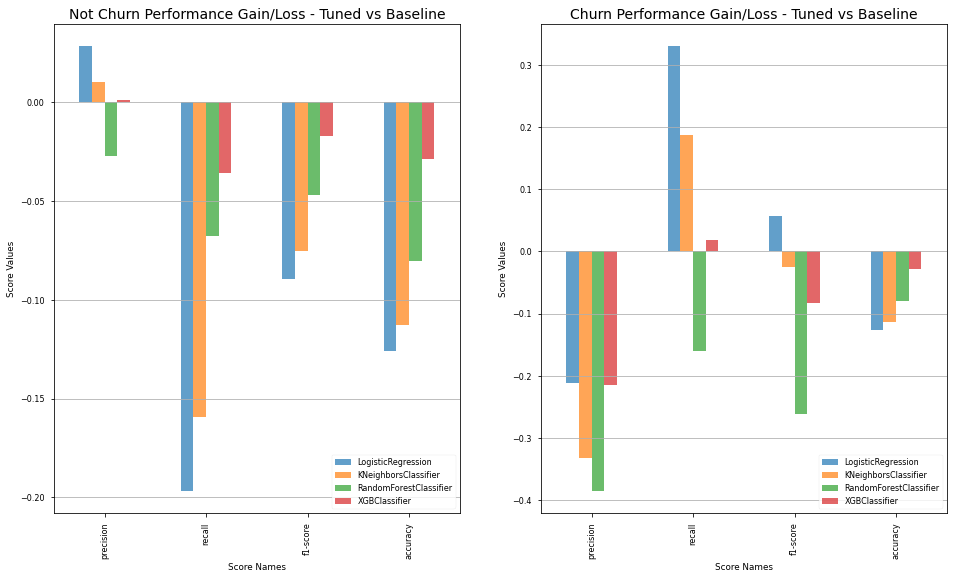

In [45]:
# Plot Performance Gain/Loss chart
plot_gain_loss(grdsch_mdl_clf_rpt, base_mdl_clf_rpt, {'f_churn': 'Not Churn',
                                                      't_churn': 'Churn'},
                                                      'Tuned vs Baseline' )

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>There are more decreases than increases in the 4 scores.  Logistic Regression gained the most in the precision score after the hyperparameter tuning.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Similar behaviors can be observed here with Logistic Regression benefited the most from the tuned parameters.</li>
    </ul>
    <p>--- Conclusion ---</p>
        <ul>
            <li>Based on the classification report charts, XGBoost is clearly the superior model.  We will use it for the next step, model evaluation. </li>
        </ul>
</div>

***
## Model Evaluation

### Model Validation

In [46]:
# Compare train, test accuracy score
mdl_a_xg_clf = xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=250)

y_test_pred, y_train_acc, y_test_acc = mdl_validation('xgb', mdl_a_xg_clf, df_smote)

print(f'\n***** Train Accuracy: {y_train_acc * 100}%. ' +
      f'Test Accuracy:{round(y_test_acc * 100,2)}% *****')


***** Train Accuracy: 100.0%. Test Accuracy:92.57% *****


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The test Accuracy score is more than 5% lower than the training scores, which might suggest an issue with the model being overfitted.</li>
    </ul>
</div>

### Plot ROC Curve


***** AUC Score: 83.64% *****


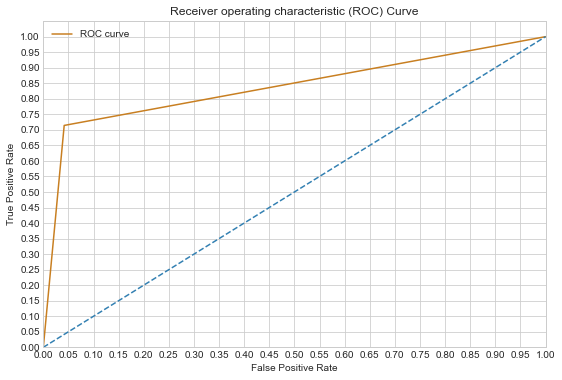

In [47]:
# Plot ROC curve
plot_roc_cur(y_test, y_test_pred, sec=None)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Our model produced a Area under the Curve (AUC) score of 0.812.  In other words, the model correctly distinguished between 'Churn' and 'Not Churn' at approximately 81% of the time.</li>
        <li>We will refer to this model as Model A.</li>
    </ul>
</div>

***
# Alternate Model - Model B

In Model A we grouped States by region for the sake of simplicity.  Perhaps, the geographic data might provide additional insights as to why and where the churn happen. Here we will construct another model without grouping the States by Region. It will be referred to as model B.

***
## Model B - Import Data

In [48]:
# Create a new daaframe without the States grouping
df_alt = df.copy()

In [49]:
# View data
df_alt.head()

state  account length  area code international plan voice mail plan  \
0    KS             128        415                 no             yes   
1    OH             107        415                 no             yes   
2    NJ             137        415                 no              no   
3    OH              84        408                yes              no   
4    OK              75        415                yes              no   

   number vmail messages  total day minutes  total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total day charge  total eve minutes  total eve calls  total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1      0  
1                       1      0  
2                       0      0  
3                       2      0  
4                       3      0

***
## Model B - Clean and Scrub Data

In [50]:
# Drop the area code column
df_alt.drop(columns='area code', axis=1, inplace=True)

# Verify drop
(df_alt.columns == 'area code').sum()

0

In [51]:
# Drop 'total day charge', 'total eve charge', 'total night charge'
# and 'total intl charge' due to perfect correlation
col_to_drop = ['total day charge', 'total eve charge',
               'total night charge', 'total intl charge'] 

df_alt.drop(columns=col_to_drop, axis=1, inplace=True)

# Verify drop
len([col for col in df_alt.columns if 'charge' in col])

0

***
## Model B - Explore Data

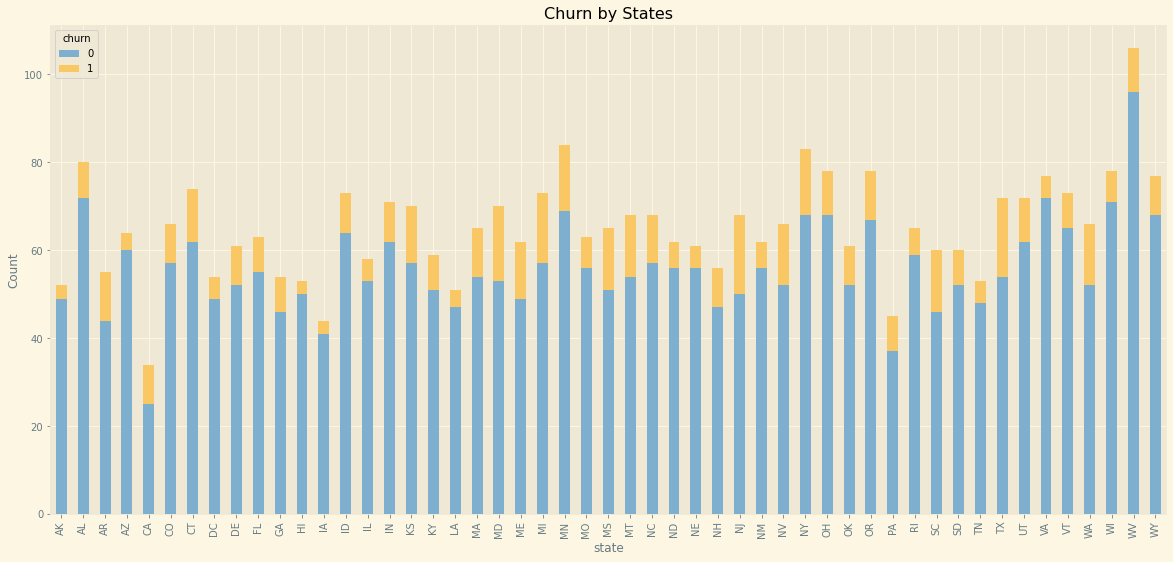

In [52]:
# Plot the churn rate by States
with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(figsize=(20,9))
    df_alt.groupby(['state', 'churn']).size().unstack().plot(kind='bar',
                                                             stacked=True,
                                                             color=['#7FAFCE','#F9C764'],
                                                             ax=axes)
    plt.ylabel('Count')
    plt.title('Churn by States')
    plt.show()

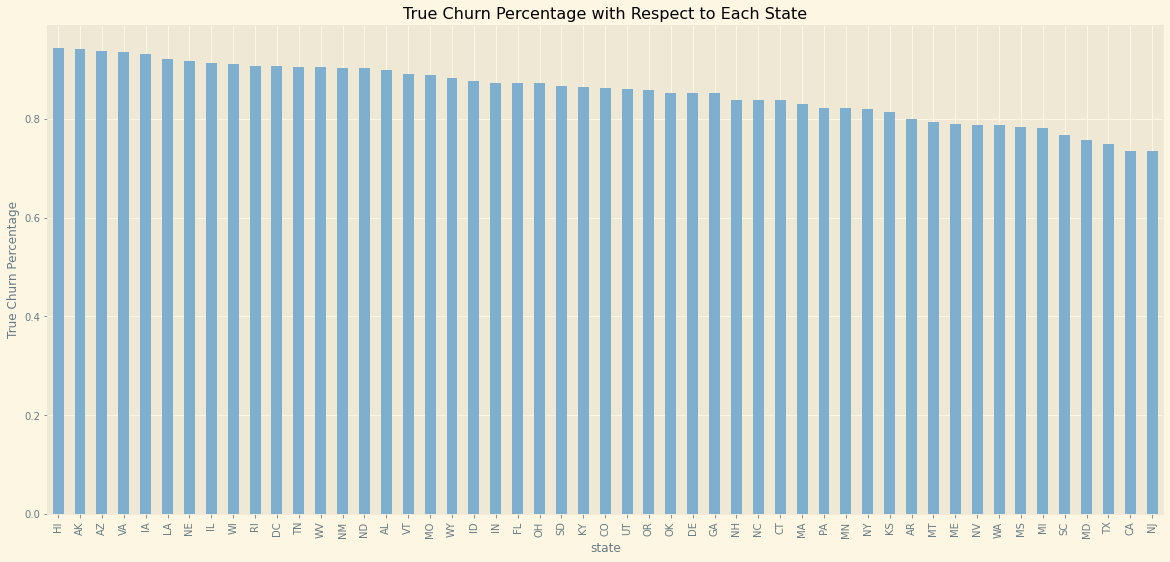

In [53]:
# Plot the true churn rate percentage per State
state_true_c = (df_alt.groupby('state')['churn'].
                value_counts(normalize=True).unstack()[0].sort_values(ascending=False))

with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(figsize=(20,9))
    state_true_c.plot(kind='bar', stacked=True, color='#7FAFCE', ax=axes)
    plt.ylabel('True Churn Percentage')
    plt.title('True Churn Percentage with Respect to Each State')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The top 5 Sates with the highest Churn rates are HI, AK, AZ, VA and IA.</li>
    </ul>
</div>

***
## Model B - Premodeling Preparations

### Create Train Test Split

In [54]:
# Separate labels and features
y_b = df_alt.churn.copy()
X_b = df_alt.drop(columns='churn', axis=1).copy()


X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b,
                                                            y_b,
                                                            test_size=0.25,
                                                            random_state=36 )
print(X_b_train.shape, X_b_test.shape)

(2499, 14) (834, 14)


### One Hot Encoding

In [55]:
# One hot encoding test data
X_b_train_ohe = pd_ohe(X_b_train)

# Preview data
X_b_train_ohe.head()

state_AL  state_AR  state_AZ  state_CA  state_CO  state_CT  state_DC  \
996          0         0         0         0         0         0         0   
1396         0         0         0         0         0         0         0   
2421         0         0         0         0         1         0         0   
642          0         0         0         0         0         0         0   
2191         0         0         0         0         0         0         0   

      state_DE  state_FL  state_GA  ...  number vmail messages  \
996          0         0         0  ...                      0   
1396         0         0         0  ...                     27   
2421         0         0         0  ...                      0   
642          0         0         0  ...                      0   
2191         0         0         0  ...                      0   

      total day minutes  total day calls  total eve minutes  total eve calls  \
996               116.1              101              201.8               99   
1396              188.9              124              160.9              102   
2421              197.8               66              133.9              119   
642               195.0               92              210.5               83   
2191               90.6              130              170.6              100   

      total night minutes  total night calls  total intl minutes  \
996                 181.9                103                11.6   
1396                197.7                100                11.5   
2421                177.3                 94                10.9   
642                 180.6                 92                11.0   
2191                137.4                 74                 5.4   

      total intl calls  customer service calls  
996                  5                       0  
1396                 5                       4  
2421                 3                       4  
642                 13                       0  
2191                 9                       1  

[5 rows x 63 columns]

In [56]:
# One hot encoding test data
X_b_test_ohe = pd_ohe(X_b_test)

# Preview data
X_b_test_ohe.head()

state_AL  state_AR  state_AZ  state_CA  state_CO  state_CT  state_DC  \
1038         0         0         0         1         0         0         0   
3241         0         0         0         0         0         0         0   
1523         0         0         0         0         0         0         0   
532          0         0         0         0         0         0         0   
1013         0         0         0         0         0         0         0   

      state_DE  state_FL  state_GA  ...  number vmail messages  \
1038         0         0         0  ...                      0   
3241         0         0         0  ...                      0   
1523         0         0         0  ...                      0   
532          0         0         0  ...                     38   
1013         0         0         0  ...                      0   

      total day minutes  total day calls  total eve minutes  total eve calls  \
1038              111.9               92              114.0              143   
3241              248.7              118              172.3               73   
1523              115.1               89              196.8              111   
532               213.7               61              253.0              104   
1013              156.2               93              193.0               54   

      total night minutes  total night calls  total intl minutes  \
1038                146.8                 79                14.1   
3241                191.9                 87                11.3   
1523                212.4                 98                11.4   
532                 207.7                 73                10.7   
1013                222.7                 94                13.1   

      total intl calls  customer service calls  
1038                 3                       5  
3241                 2                       1  
1523                 3                       2  
532                  5                       2  
1013                 5                       1  

[5 rows x 63 columns]

***
## Model B - Baseline Model

### Fit Model

In [57]:
# Assign X, y train, test to variable
df_b_baseline = [X_b_train_ohe, y_b_train, X_b_test_ohe, y_b_test]

In [58]:
# Define list of classifiers to feed to pipeline
b_clfs = [LogisticRegression(random_state=36), KNeighborsClassifier(),
        RandomForestClassifier(random_state=36), xgb.XGBClassifier(random_state=36)]

### Plot Confusion Matrix

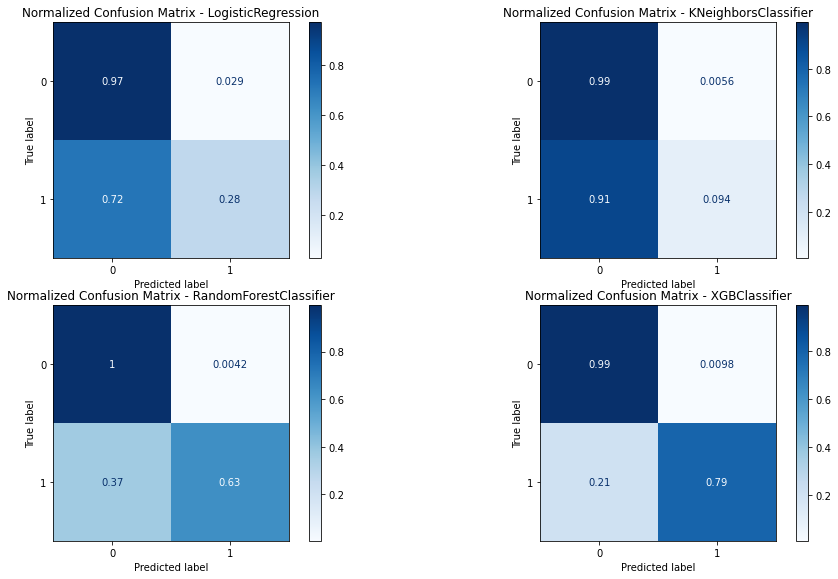

In [59]:
# Fit model, generate classifcation report and plot confusion matrix
b_base_mdl_clf_rpt, b_clf_dict = fit_eval_clf(b_clfs, df_b_baseline)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>XGBoost in this model produced a higher recall score, 0.79 vs 0.71 in Model A. KNN did the worst with a true positive prediction of 0.094.</li>  
    </ul>
</div>

### Plot Comparison Chart

In [60]:
# Display model classification report
b_base_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.892308  0.970711  0.929860  717.000000   
Churn                  0.611111  0.282051  0.385965  117.000000   
accuracy               0.874101  0.874101  0.874101    0.874101   
macro avg              0.751709  0.626381  0.657912  834.000000   
weighted avg           0.852859  0.874101  0.853558  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.870574  0.994421  0.928385  717.000000   
Churn                    0.733333  0.094017  0.166667  117.000000   
accuracy                 0.868106  0.868106  0.868106    0.868106   
macro avg                0.801954  0.544219  0.547526  834.000000   
weighted avg             0.851321  0.868106  0.821526  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.943197  0.995816  0.968792  717.000000   
Churn                      0.961039  0.632479  0.762887  117.000000   
accuracy                   0.944844  0.944844  0.944844    0.944844   
macro avg                  0.952118  0.814147  0.865839  834.000000   
weighted avg               0.945700  0.944844  0.939906  834.000000   

             XGBClassifier                                 
                 precision    recall  f1-score    support  
Not Churn         0.967302  0.990237  0.978635  717.00000  
Churn             0.930000  0.794872  0.857143  117.00000  
accuracy          0.962830  0.962830  0.962830    0.96283  
macro avg         0.948651  0.892554  0.917889  834.00000  
weighted avg      0.962069  0.962830  0.961592  834.00000

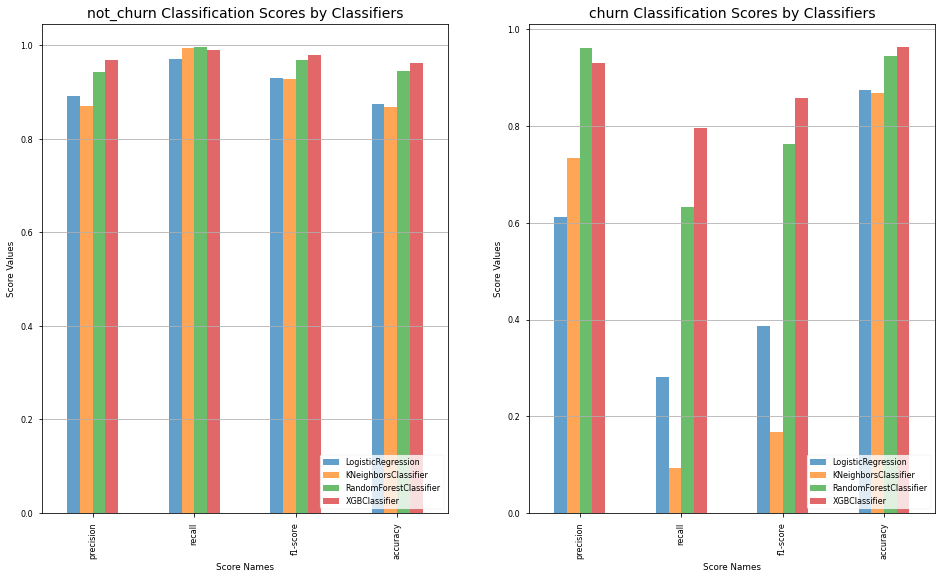

In [61]:
# Plot comparison chart
plot_clf_rpt(b_base_mdl_clf_rpt, b_clf_dict)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>All four model did pretty well in this area.  Again XGBoost outperformed the other three in most scores.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>KNN have a very low recall and f1_score so is Logistic Regression.  XGBoost led the pack in this baseline model evaluation.</li>
        </ul>
</div>

***
## Model B - Fine Tune Model

### Address Class Imbalance Problems

In [62]:
# Use SMOTE since we don't have a lot of features and data, computational issues are mininum
smote = SMOTE()
X_b_train_smote, y_b_train_smote = smote.fit_sample(X_b_train_ohe,
                                                    y_b_train)

# Check new train dataset
print(pd.Series(y_b_train_smote.value_counts()))

1    2133
0    2133
Name: churn, dtype: int64


### Model B - Grid Search Hyperparameters

In [63]:
# Establish GridSearch parameter grids for the models

# fit_intercept, add bias if true.  Small C = stronger regularization
# Since sample data are quite small and doesn't involve multi class, set solver to liblinear
# liblinear only works with penalty 'l1', omit 'l2' from parameter
lr_params = {'lr__fit_intercept': [True, False],
             'lr__C': [0.001,0.01,0.1,1,10,100,1000],
             'lr__penalty': ['l1'],
             'lr__solver': ['liblinear']}

# A lower n_neighbors = more complex model.  Distance in weight means closer neighbors
# of a query point will have a greater influnce.
knn_params = {'knn__n_neighbors': list(range(1, 33, 2)),
              'knn__metric': ['euclidean', 'minkowski'],
              'knn__weights': ['uniform', 'distance']}

# n_estimators = number of trees in the foreset; max_features = max number of features
# considered for splitting a node; max_dept = max number of levels in each decision tree
# min_samples_leaf = min number of data points allowed in a leaf node
rf_params = {'rf__n_estimators': [5, 30, 100, 170, 250],
             'rf__max_features': ['auto', 'sqrt', 'log2'],
             'rf__max_depth' : [4,5,6,7,8],
             'rf__min_samples_leaf': [3, 5, 7]}

# min_child_weight = min_sample_leaf; 
xg_params = {'xg__n_estimators': [5, 30, 100, 170, 250],
             'xg__max_depth': range(3,10,2),
             'xg__min_child_weight': list(range(1,6,2)),
             'xg__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# Set up functions parameters
b_alg_dict = {'lr': LogisticRegression(max_iter=10000, random_state=36),
              'knn': KNeighborsClassifier(),
              'rf': RandomForestClassifier(random_state=36),
              'xg': xgb.XGBClassifier(random_state=36)}

b_mdl_params = {'lr_grd_sch': lr_params, 'knn_grd_sch': knn_params,
              'rf_grd_sch': rf_params , 'xg_grd_sch': xg_params}

In [64]:
# Assing X, y train, test to variables
df_b_smote = [X_b_train_smote, y_b_train_smote, X_b_test_ohe, y_b_test]

In [65]:
# Run gridsearchcv.  Cell takes about 25-40 min to run without setting n_jobs=-1.
# Tried n_job=1 but it messed up the timer.
df_b_grdsch_mdl = fit_evl_grdsch(b_alg_dict, b_mdl_params, df_b_smote)

running gridsearch for lr
total elapsed time 00:00:12
running gridsearch for knn
total elapsed time 00:01:16
running gridsearch for rf
total elapsed time 00:06:01
running gridsearch for xg
total elapsed time 00:27:54


In [66]:
# View results
df_b_grdsch_mdl.head()

no_model exec_time                                        best_params  \
lr         14  00:00:12  {'lr__C': 10, 'lr__fit_intercept': True, 'lr__...   
knn        64  00:01:16  {'knn__metric': 'euclidean', 'knn__n_neighbors...   
rf        225  00:06:01  {'rf__max_depth': 8, 'rf__max_features': 'auto...   
xg        360  00:27:54  {'xg__learning_rate': 0.2, 'xg__max_depth': 9,...   

                                              best_est  best_score  
lr   (StandardScaler(), LogisticRegression(C=10, ma...    0.820601  
knn  (StandardScaler(), KNeighborsClassifier(metric...    0.842619  
rf   (StandardScaler(), (DecisionTreeClassifier(max...    0.794197  
xg   (StandardScaler(), XGBClassifier(learning_rate...    0.938117

In [67]:
# View best estimators
print(df_b_grdsch_mdl.best_est.values)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=10, max_iter=10000, penalty='l1',
                                    random_state=36, solver='liblinear'))])
 Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])
 Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=5,
                                        n_estimators=5, random_state=36))])
 Pipeline(steps=[('scaler', StandardScaler()),
                ('xg',
                 XGBClassifier(learning_rate=0.2, max_depth=9,
                               min_child_weight=3, n_estimators=250,
                               random_state=36))])]


### Fit Model with New Parameters

In [68]:
# Define list of classifiers to feed to pipeline
b_grdsch_clfs = []
for i in range(len(df_b_grdsch_mdl.best_est.values)):
    est = df_b_grdsch_mdl.best_est.values[i][-1]
    print(est)
    b_grdsch_clfs.append(est)

LogisticRegression(C=10, max_iter=10000, penalty='l1', random_state=36,
                   solver='liblinear')
KNeighborsClassifier(metric='euclidean', n_neighbors=1)
RandomForestClassifier(max_depth=8, min_samples_leaf=5, n_estimators=5,
                       random_state=36)
XGBClassifier(learning_rate=0.2, max_depth=9, min_child_weight=3,
              n_estimators=250, random_state=36)


### Plot Confusion Matrix

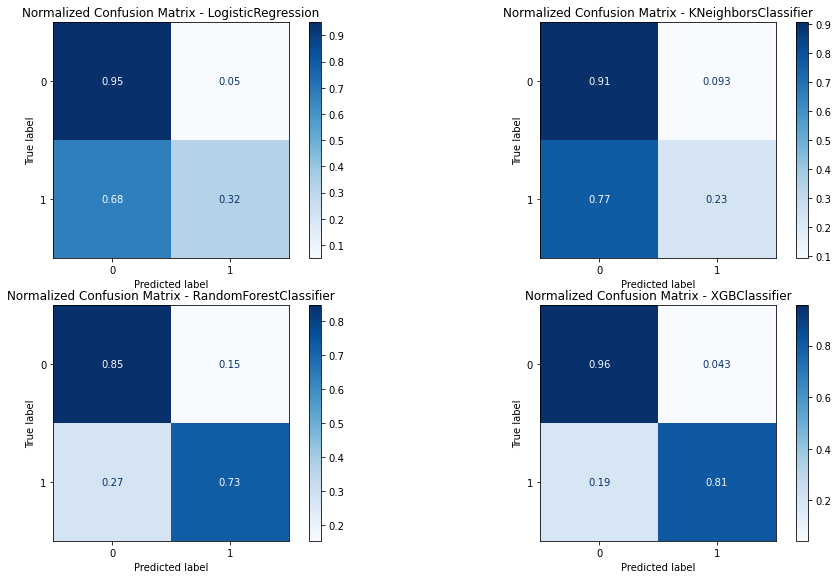

In [69]:
# Fit model with best estimators
b_grdsch_mdl_clf_rpt, b_grdsch_clf_dict = fit_eval_clf(b_grdsch_clfs, df_b_smote)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Not much improvement on predicting true negative.  But XGBoost did increased it true positive prediction slightly after the hyperparameter tuning.  KNN performed the worst for true positive prediction.</li>
    </ul>
</div>

### Plot Comparison Chart

In [70]:
# View classification report
b_grdsch_mdl_clf_rpt

LogisticRegression                                 \
                      precision    recall  f1-score    support   
Not Churn              0.896053  0.949791  0.922139  717.00000   
Churn                  0.513514  0.324786  0.397906  117.00000   
accuracy               0.862110  0.862110  0.862110    0.86211   
macro avg              0.704783  0.637289  0.660023  834.00000   
weighted avg           0.842387  0.862110  0.848596  834.00000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.878378  0.906555  0.892244  717.000000   
Churn                    0.287234  0.230769  0.255924  117.000000   
accuracy                 0.811751  0.811751  0.811751    0.811751   
macro avg                0.582806  0.568662  0.574084  834.000000   
weighted avg             0.795448  0.811751  0.802976  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.949922  0.846583  0.895280  717.000000   
Churn                      0.435897  0.726496  0.544872  117.000000   
accuracy                   0.829736  0.829736  0.829736    0.829736   
macro avg                  0.692910  0.786539  0.720076  834.000000   
weighted avg               0.877810  0.829736  0.846122  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.968927  0.956764  0.962807  717.000000  
Churn             0.753968  0.811966  0.781893  117.000000  
accuracy          0.936451  0.936451  0.936451    0.936451  
macro avg         0.861447  0.884365  0.872350  834.000000  
weighted avg      0.938771  0.936451  0.937427  834.000000

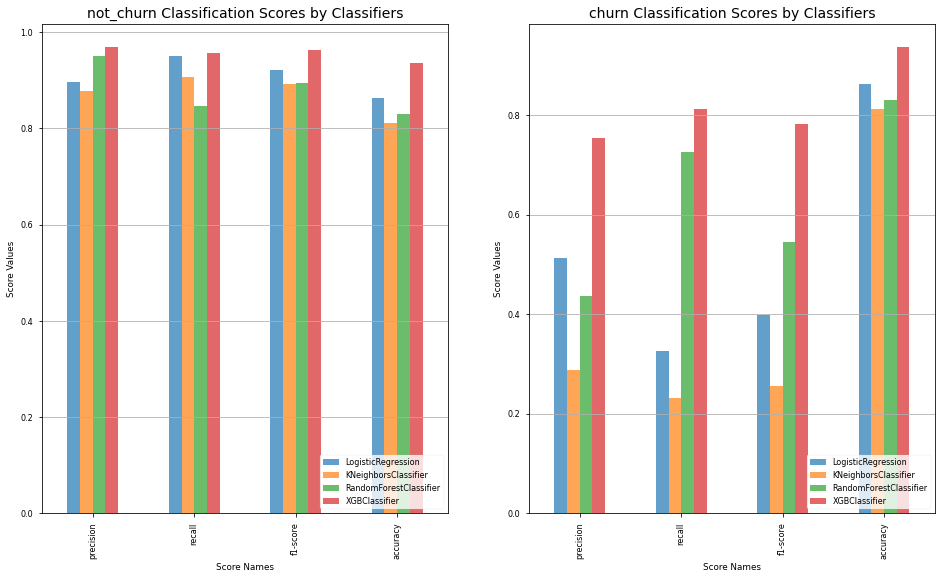

In [71]:
# Plot comparison chart
plot_clf_rpt(b_grdsch_mdl_clf_rpt, b_grdsch_clf_dict)

### Plot Performance Gain/Loo Tuned vs Base

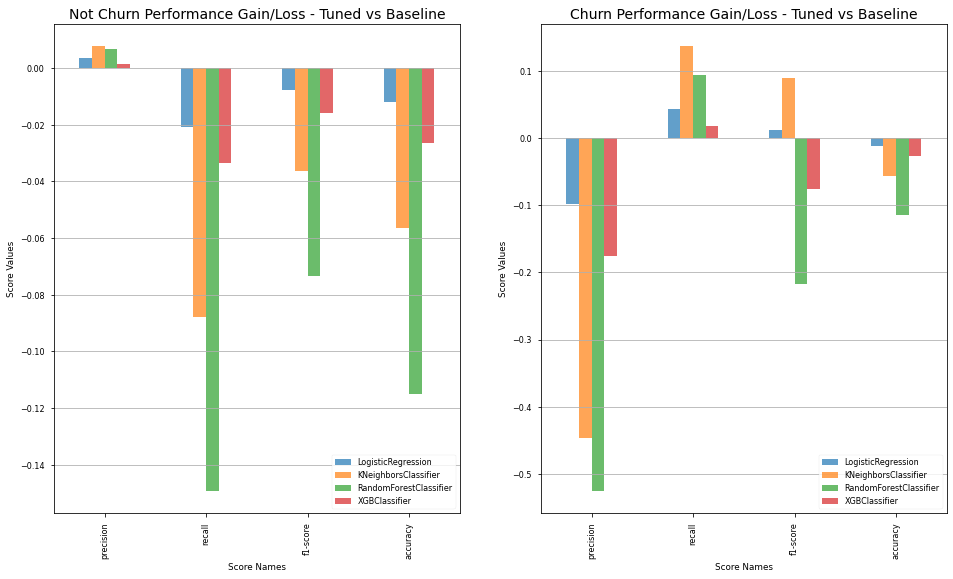

In [72]:
# Plot Performance Gain/Loss chart
plot_gain_loss(b_grdsch_mdl_clf_rpt, b_base_mdl_clf_rpt, {'f_churn': 'Not Churn',
                                                          't_churn': 'Churn'},
                                                          'Tuned vs Baseline')

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Random Forest gained the most in performance from the tunning.  The other three classifiers only showed a decrease in performance compared to based model.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>A drop in most scores across the four classifiers.  Good news is that Random Forest and XGBoost showed again in the recall score.</li>
        </ul>
    <p>--- Conclusion ---</p>
         <ul>
            <li>XGBoost still yields the best scores among the models, especially the recall scores, which is what we are trying to optimize.  We will pick XGBoost as the model of choice for Model B. </li>
        </ul>   
</div>

***
## Model B - Model Evaluation

### Model Validation

In [73]:
# Compare train, test accuracy score
mdl_b_xg_clf = xgb.XGBClassifier(learning_rate=0.2, max_depth=7,
                                 n_estimators=250, random_state=36)

y_b_test_pred, y_b_train_acc, y_b_test_acc = mdl_validation('xgb', mdl_a_xg_clf, df_b_smote)

# y_b_test_pred, y_b_train_acc, y_b_test_acc = mdl_validation('xgb', mdl_a_xg_clf,
#                                                       X_b_train_smote, y_b_train_smote,
#                                                       X_b_test_ohe, y_b_test)

print(f'\n***** Train Accuracy: {y_b_train_acc * 100}%. ' +
      f'Test Accuracy:{round(y_b_test_acc * 100,2)}% *****')


***** Train Accuracy: 99.92999999999999%. Test Accuracy:94.6% *****


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Model B test accuracy score went up significantly, from 92.09% in Model A to 94.84%.</li>
        <li>Model B appears to be less overfitted.</li>
    </ul>
</div>


***** Model A AUC Score: 83.64% *****

***** Model B AUC Score: 88.28% *****


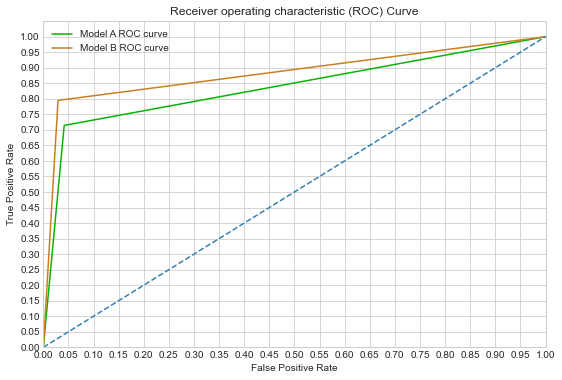

In [74]:
plot_roc_cur(y_b_test, y_b_test_pred, y_test, y_test_pred, sec=True)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Model B has a higher AUC score than Model A 88.06% vs 83.36%..</li>
    </ul>
</div>

### Plot Performance Gain/Loss - Model B vs Model A

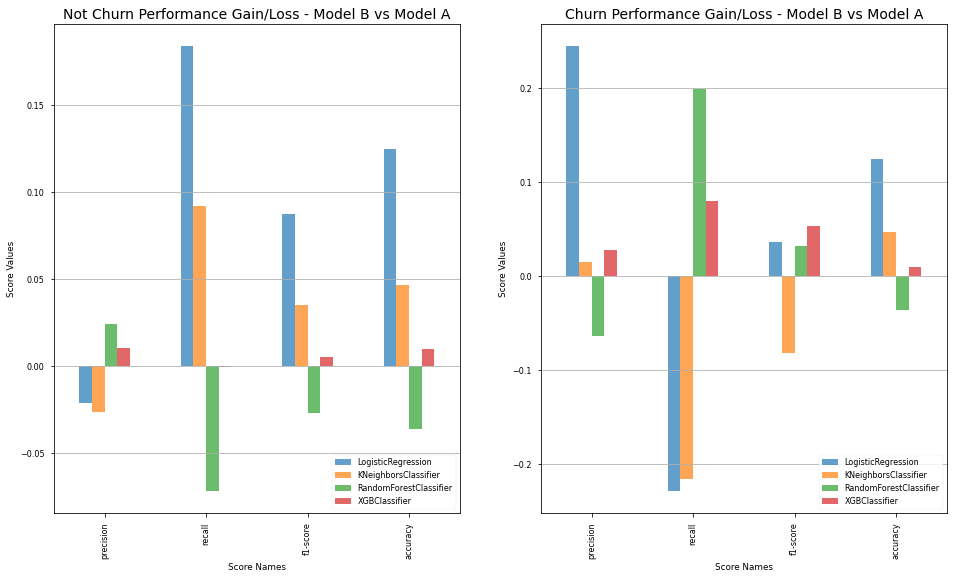

In [75]:
# Plot Performance Gain/Loss chart
plot_gain_loss(b_grdsch_mdl_clf_rpt, grdsch_mdl_clf_rpt, {'f_churn': 'Not Churn',
                                                          't_churn': 'Churn'},
                                                          'Model B vs Model A')

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The XGBoost in Model B outperformed Model A in all aspect of the scores.</li>
        <li>Model B will be our final model and we will use in our next step, model interpretation.</li>
    </ul>
</div>

***
## Model Interpretation

### Prepare Data for Shap

In [76]:
# load JS visualization code to notebook
shap.initjs()

# Setup pipeline, transform data
xgb_pipe = Pipeline([('scaler', StandardScaler())])
x_b_train_smote_tmp = xgb_pipe.fit_transform(X_b_train_smote)
X_b_test_ohe_tmp = xgb_pipe.transform(X_b_test_ohe)

x_b_train_smote_sca = pd.DataFrame(x_b_train_smote_tmp, columns=X_b_train_smote.columns)
X_b_test_ohe_sca = pd.DataFrame(X_b_test_ohe_tmp, columns=X_b_test_ohe.columns)

# Fit model
xgb_clf =  mdl_b_xg_clf
xgb_clf.fit(x_b_train_smote_sca, y_b_train_smote)         

XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=250, random_state=36)

In [77]:
# !!! This cell takes about 5 mins to run !!!
# Compute shap values
explainer = shap.TreeExplainer(xgb_clf, x_b_train_smote_sca)
shap_values = explainer.shap_values(X_b_test_ohe_sca)

Passing 4266 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 831/834 [03:35<00:00]        

### Feature Important

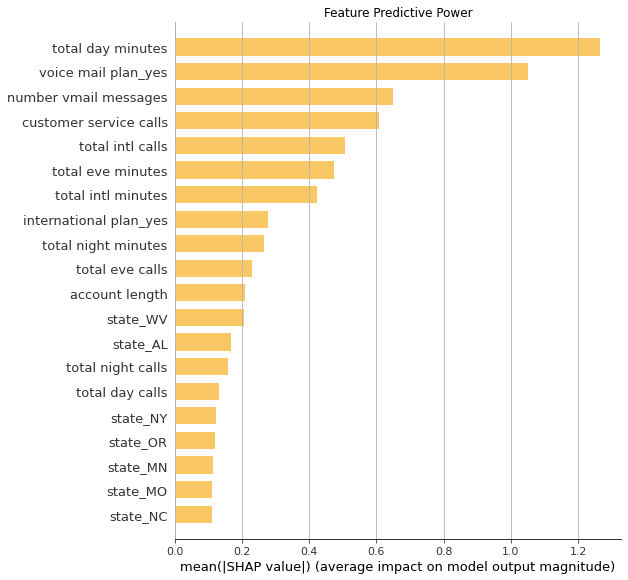

In [78]:
# plot feature important
fig = shap.summary_plot(shap_values, X_b_test_ohe_sca, plot_type="bar"
                        , show=False, color='#F9C764')
plt.title('Feature Predictive Power')
plt.grid(axis='x')
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The 'total day minutes' and 'voice mail plan_yes' features have the biggest impact on the model outcome. It changes the predicted churn probability by about 120% (approx. 1.2 on the x-axis) and 98% on average respectively.</li>
        <li>The 'number vmail messages' and 'customer service calls' came in third and fourth as the most influential features.</li>
    </ul>
</div>

### Shap Values Distribution by Features

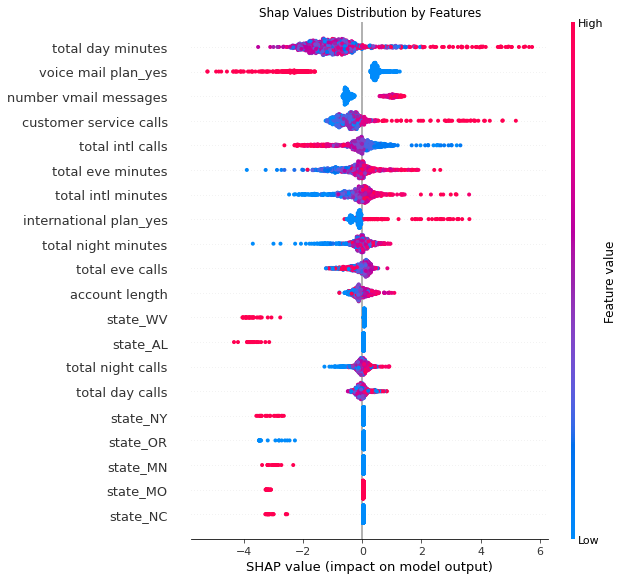

In [79]:
# Plot the Shap summary report which combines feature importance with feature effects
fig = shap.summary_plot(shap_values, X_b_test_ohe_sca, show=False)
plt.title('Shap Values Distribution by Features')
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In general, the higher the actual feature values in 'total day minutes' (red dots), the higher the prediction in the 'churn' label.  On the hand, the lower their actual feature values (blue dots), reduce the prediction for the 'churn' label.</li>
        <li>Customers with voice mail plan tend not to leave while customers without a voice mail plan contribute more toward the the churn label prediction.</li>
        <li>High feature values in 'number vmial messages' has a positive impact in predicting the 'churn' label in the model outcomes.</li>
        <li>For feature 'customer service calls', the higher the number of calls to the customer service line, the higher the risk that the customers will leave.</li>
    </ul>
</div>

### Examine Individual Instance

In [80]:
# Find instances of 'Churn' & 'Not Churn'
n_churn_row = (y_b_test == 0).values.nonzero()[0][0]
churn_row = (y_b_test == 1).values.nonzero()[0][0]

In [81]:
# Examine features influnces on 'Not Churn' prediction
shap.force_plot(explainer.expected_value, shap_values[n_churn_row,:],
                X_b_test_ohe_sca.iloc[n_churn_row,:])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In this instance, the actual churn rate is False or 0.  Here we can how the the features in the model is working together to come to a false prediction.
        <li>In this case, the 'state_NV', 'total day minutes', 'customer services calls' and other features are pushing toward a False prediction while features like, 'voice mail plan_yes' and 'total intl minutes' are acting in the opposite direction.  Since the negative forces outweigh the positive forces, they push the model toward a False prediction.</li>
    </ul>
</div>

In [82]:
# Examine features influnces on 'Churn' prediction
shap.force_plot(explainer.expected_value, shap_values[churn_row,:],
                X_b_test_ohe_sca.iloc[churn_row,:])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In this instance, the actual value for the churn rate is true.  We can see how the model use the aggregate effects of 'customer service calls', 'total day minutes' and 'state_CA' to predict a true churn rate.</li>
    </ul>
</div>

### Global Instance Influence

In [83]:
# !!! Please select the top 4 features from the top dropdown for
#     the comments in the 'Observation' section !!!

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_b_test_ohe_sca)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>This figure plots all the instance we saw above.  It show how each feature value has on the model outcomes.  The bigger the red area, more impact in predicting churn.  Blue area are the negative forces that push to reduce risk of churn.</li>
    </ul>
</div>

***
## Conclusion

<b>Our Classifier</b>
    <p>All of the selected supervised learning methods in this project are capable of tackling binary classification.  Each have their strengths and weaknesses for different business situations.  In our case of predicting the Churn rate, the XGBoost classifier out performed the other three classifiers in term of the accuracy, f1_score, precision and recall scores.  Especially the recall score because we need to identify all potential customers that are like to cancel their services.</p>
        <p>We picked Model B because Model B have a higher scorings in the classification report than Model A.  Furthermore, Model B seems to be less overfitting than Model A.  Lastly, Model B AUC score is significantly higher than Model A.</p>
        
<b>Recommendations</b>    
    <p>Based on the available data, our model is able to identify which explanatory variables have the biggest impact on the Churn rate.  We will based our recommendations based on our top four features.<p>
    <ol>
        <li><p>'Total day minutes': Customers with high number of minutes used during the day, have a greater chance of churn.  A remedy to such problem would be to review the pricing structure for total day minutes.  Perhaps, we can micro-segment the pricing structure for total day minutes charges.</p>
            <p>Another approach we can implement is to model what the airline industry is offering to their customer with the 'frequent-flyer miles'.  We could grand the heavy day time usage customers with VIP status and they will receive certain amount of benefits when they reach certain usage level.  Thus providing the justification to make more or longer call without feeling spending more.</p>
        </li>  
        <li>'Voice mail plan_yes':  Customers without a voice mail plan tend to end their services with the company.  It is possible that they find other competitors offering such feature without addition charges.  We should carry out a comparative analysis to see if we can match the competitions, in order to keep the customers happy.
        </li>
        <li>'No vmail messages': Are we charging customers when they exceed certain amount of voice mails?  Do they have a time length limit for storing voice messages?  Understanding what our competitors are offering is critical so we can provide competitive offerings.  Another point to take into consideration is the capacity of our infrastructure.  Usage analysis and capacity planning will need to be carried out so that new offerings by our company will not overtax on our daily operations.</li>
        <li>'Customer service calls':  The model indicates that customers with high number of service calls show higher risk of churn.  A analysis of the call nature will help us prioritize area of improvements.  Questions like is the call information or technical?  Are customers calling with the same questions?  If yes, it would suggest that more training are needed for the customer service agents. </li>
    </ol>
<b>Future work</b>
    <ol>
        <li>In this project, we have selected four different types of supervised learning algorithms namely, Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost, because each classifier employs different algorithm to optimize their predictions.  It would be interesting to see what type of results we could obtain, if we were to use other algorithms, such as Bayesian Classification or the Support Vector Machines.</li>
        <li>We can also try different techniques to deal with class imbalance problems, for instance, using oversampling and undersampling as well as combining over or undersampling with SMOTE.  
        <li>Each classifier come with number of parameters for fine tuning.  Finding the best combination of parameters can be computationally expensive.  In this project we selected the most common parameters for fine tuning.  If time allows, we can introduce more hyperparameters for each classifier to the grid search method and see where it will bring us in term of the model performances.